In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import prince
import factor_analyzer
import pickle

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

 
from numpy import mean
from numpy import std
from numpy import arange
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV # For optimization

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import prince
import pickle

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [2]:
data = pd.read_csv("twitter-featured.csv")
data = data.drop('Unnamed: 0', axis=1)
data.head()

,Winner,T1_TwitterVol,T2_TwitterVol,T1_FansSent,T2_FansSent,T1_FansPred,T2_FansPred
0,0,0.571429,0.428571,0.571429,0.380952,0.000000,0.000000
1,0,0.837838,0.162162,0.648649,0.162162,0.000000,0.000000
2,1,0.356688,0.643312,0.299363,0.535032,0.333333,0.666667
3,0,0.464286,0.535714,0.464286,0.464286,0.000000,0.000000
4,1,0.695652,0.304348,0.565217,0.282609,0.000000,0.000000


In [3]:
# train test split
train, test= train_test_split(data, test_size = 0.2, random_state = 100)

In [4]:
train.shape, test.shape

((415, 7), (104, 7))

In [5]:
train.columns

Index(['Winner', 'T1_TwitterVol', 'T2_TwitterVol', 'T1_FansSent',
       'T2_FansSent', 'T1_FansPred', 'T2_FansPred'],
      dtype='object')

In [6]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()   
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:  
                colname = corr_matrix.columns[i]   
                col_corr.add(colname)
    return col_corr

correlation(train.iloc[:,:-1],0.8)

{'T1_FansSent', 'T2_FansSent', 'T2_TwitterVol'}

In [7]:
xtrain = train.drop(['Winner'],axis=1) 
ytrain = train['Winner']
 
xtest = test.drop(['Winner'],axis=1)  
ytest = test['Winner']

xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((415, 6), (104, 6), (415,), (104,))

In [8]:
st = StandardScaler()
xtrain  = st.fit_transform(xtrain)
xtest = st.fit_transform(xtest)

In [9]:
sm = SMOTE(random_state=100)
xtrain_sm, ytrain_sm = sm.fit_resample(  xtrain,ytrain) 
 
xtrain_sm.shape, ytrain_sm.shape 

((486, 6), (486,))

## Logistic regression - with hyperparameter tuning

### Laasso penalty

In [20]:
logModel  = LogisticRegression(random_state=42)

param_grid = [    
    {'solver' : [ 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'newton-cholesky'],
    'penalty' : [   'l1'  ], #'None', 'l1', 'l2', 'elasticnet'
    'C' :  [1e-5, 1e-4, 1e-3, 1e-2, 1e-1 ],
    'max_iter': [2000]
    }
]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
log_grid = GridSearchCV(logModel, param_grid = param_grid , verbose=True, n_jobs=-1, cv=cv , scoring='f1')
log_clf_hyp = log_grid.fit(xtrain_sm,ytrain_sm)

Fitting 30 folds for each of 30 candidates, totalling 900 fits


In [21]:
log_clf_hyp.best_estimator_

LogisticRegression(C=0.1, max_iter=2000, penalty='l1', random_state=42,
                   solver='saga')

In [22]:
log_clf_hyp.best_params_, log_clf_hyp.best_score_

({'C': 0.1, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'},
 0.631139025394043)

In [23]:
# Predict the train data
y_predicted = log_clf_hyp.predict(xtrain_sm)

print('\nclassification report - logistice (l1) - train')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print('LogReg: ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report - logistice (l1) - train
              precision    recall  f1-score   support

           0       0.65      0.58      0.61       243
           1       0.62      0.68      0.65       243

    accuracy                           0.63       486
   macro avg       0.63      0.63      0.63       486
weighted avg       0.63      0.63      0.63       486

LogReg: ROC AUC =  63.2 %
LogReg: Precision =  61.9 %
LogReg: Recall =  68.3 %
LogReg: Accuracy =  63.2 %
LogReg: F1-Score =  65.0 %


array([[141, 102],
       [ 77, 166]], dtype=int64)

In [24]:
# Predict the test data
y_predicted = log_clf_hyp.predict( xtest)

print('\nclassification report - logistic(l2)+SMOTE - test ')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('LogReg: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report - logistic(l2)+SMOTE - test 
              precision    recall  f1-score   support

           0       0.55      0.55      0.55        49
           1       0.60      0.60      0.60        55

    accuracy                           0.58       104
   macro avg       0.58      0.58      0.58       104
weighted avg       0.58      0.58      0.58       104

LogReg: ROC AUC =  57.6 %
LogReg: Precision =  60.0 %
LogReg: Recall =  60.0 %
LogReg: Accuracy =  57.7 %
LogReg: F1-Score =  60.0 %


array([[27, 22],
       [22, 33]], dtype=int64)

In [266]:
# filename = 'LR-Lasso+SMOTE.pkl'
# pickle.dump(log_clf_hyp, open(filename, 'wb'))

## ridge penalty

In [30]:
logModel  = LogisticRegression(random_state=42)

param_grid = [    
    {'solver' : [ 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'newton-cholesky'],
    'penalty' : [   'l2'  ], #'None', 'l1', 'l2', 'elasticnet'
    'C' :  [1e-5, 1e-4, 1e-3, 1e-2, 1e-1   ],
    'max_iter': [2000]
    }
]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
log_grid = GridSearchCV(logModel, param_grid = param_grid , verbose=True, n_jobs=-1, cv=cv , scoring='f1')
log_clf_hyp = log_grid.fit(xtrain_sm,ytrain_sm)

Fitting 30 folds for each of 30 candidates, totalling 900 fits


In [31]:
log_clf_hyp.best_estimator_

LogisticRegression(C=0.001, max_iter=2000, random_state=42, solver='newton-cg')

In [32]:
log_clf_hyp.best_params_, log_clf_hyp.best_score_

({'C': 0.001, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'newton-cg'},
 0.6397182630386344)

In [33]:
# Predict the train data
y_predicted = log_clf_hyp.predict(xtrain_sm)

print('\nclassification report-logistic(l2)+SMOTE-train')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print('LogReg: ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report-logistic(l2)+SMOTE-train
              precision    recall  f1-score   support

           0       0.64      0.57      0.60       243
           1       0.61      0.68      0.64       243

    accuracy                           0.62       486
   macro avg       0.62      0.62      0.62       486
weighted avg       0.62      0.62      0.62       486

LogReg: ROC AUC =  62.3 %
LogReg: Precision =  61.1 %
LogReg: Recall =  67.9 %
LogReg: Accuracy =  62.3 %
LogReg: F1-Score =  64.3 %


array([[138, 105],
       [ 78, 165]], dtype=int64)

In [34]:
# Predict the test data
y_predicted = log_clf_hyp.predict( xtest)

print('\nclassification report-logistic(l2)+SMOTE-test')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('LogReg: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report-logistic(l2)+SMOTE-test
              precision    recall  f1-score   support

           0       0.56      0.55      0.56        49
           1       0.61      0.62      0.61        55

    accuracy                           0.59       104
   macro avg       0.58      0.58      0.58       104
weighted avg       0.59      0.59      0.59       104

LogReg: ROC AUC =  58.5 %
LogReg: Precision =  60.7 %
LogReg: Recall =  61.8 %
LogReg: Accuracy =  58.7 %
LogReg: F1-Score =  61.3 %


array([[27, 22],
       [21, 34]], dtype=int64)

In [287]:
# filename = 'LR-Ridge+SMOTE.pkl'
# pickle.dump(log_clf_hyp, open(filename, 'wb'))

## elasticnet

In [35]:
logModel  = LogisticRegression(random_state=42)

param_grid = [    
    {'solver' : [ 'saga'],
    'penalty' : [   'elasticnet'  ], #'None', 'l1', 'l2', 'elasticnet'
    'C' :  [1e-5, 1e-4, 1e-3, 1e-2, 1e-1 ],
    'max_iter': [2000],
    'l1_ratio': [0.1, 0.2, 0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    }
]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
log_grid = GridSearchCV(logModel, param_grid = param_grid , verbose=True, n_jobs=-1, cv=cv , scoring='f1')
log_clf_hyp = log_grid.fit(xtrain_sm,ytrain_sm)

Fitting 30 folds for each of 45 candidates, totalling 1350 fits


In [36]:
log_clf_hyp.best_estimator_

LogisticRegression(C=0.1, l1_ratio=0.1, max_iter=2000, penalty='elasticnet',
                   random_state=42, solver='saga')

In [37]:
log_clf_hyp.best_params_, log_clf_hyp.best_score_

({'C': 0.1,
  'l1_ratio': 0.1,
  'max_iter': 2000,
  'penalty': 'elasticnet',
  'solver': 'saga'},
 0.6355505726775295)

In [38]:
# Predict the train data
y_predicted = log_clf_hyp.predict(xtrain_sm)

print('\nclassification report-logistic(enet)+SMOTE-train')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print('LogReg: ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print('LogReg: F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report-logistic(enet)+SMOTE-train
              precision    recall  f1-score   support

           0       0.65      0.60      0.62       243
           1       0.63      0.67      0.65       243

    accuracy                           0.64       486
   macro avg       0.64      0.64      0.64       486
weighted avg       0.64      0.64      0.64       486

LogReg: ROC AUC =  63.6 %
LogReg: Precision =  62.6 %
LogReg: Recall =  67.5 %
LogReg: Accuracy =  63.6 %
LogReg: F1-Score =  65.0 %


array([[145,  98],
       [ 79, 164]], dtype=int64)

In [39]:
# Predict the test data
y_predicted = log_clf_hyp.predict( xtest)

print('\nclassification report-logistic(enet)+SMOTE-test')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('LogReg: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report-logistic(enet)+SMOTE-test
              precision    recall  f1-score   support

           0       0.58      0.59      0.59        49
           1       0.63      0.62      0.62        55

    accuracy                           0.61       104
   macro avg       0.60      0.61      0.60       104
weighted avg       0.61      0.61      0.61       104

LogReg: ROC AUC =  60.5 %
LogReg: Precision =  63.0 %
LogReg: Recall =  61.8 %
LogReg: Accuracy =  60.6 %
LogReg: F1-Score =  62.4 %


array([[29, 20],
       [21, 34]], dtype=int64)

In [293]:
# filename = 'LR-Enet+SMOTE.pkl'
# pickle.dump(log_clf_hyp, open(filename, 'wb'))

## SVM1

In [294]:
from sklearn.svm import SVC

In [310]:
# define model
model = SVC(random_state=42)

# define grid search
param_grid = [    
    {'kernel' : ['poly', 'rbf'  ],
     'gamma' :['scale', 'auto' ],
    'C': [ 1, 10 ]
 
    }
]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, verbose=True, n_jobs=-1, cv=cv , scoring = 'f1', error_score=0)
grid_result = grid_search.fit(xtrain_sm, ytrain_sm)

Fitting 30 folds for each of 8 candidates, totalling 240 fits


In [311]:
grid_search.best_estimator_

SVC(C=1, random_state=42)

In [312]:
grid_search.best_params_, grid_search.best_score_

({'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}, 0.6486721008058829)

In [313]:
# Predict the train data
y_predicted = grid_search.predict(xtrain_sm)

print('\nclassification report- SVM+ SMOTE -Train')
print('\n\n')
print(classification_report(ytrain_sm, y_predicted)) 
print(' ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report- SVM+ SMOTE -Train



              precision    recall  f1-score   support

           0       0.70      0.57      0.63       243
           1       0.64      0.75      0.69       243

    accuracy                           0.66       486
   macro avg       0.67      0.66      0.66       486
weighted avg       0.67      0.66      0.66       486

 ROC AUC =  66.0 %
 Precision =  63.5 %
 Recall =  75.3 %
 Accuracy =  66.0 %
 F1-Score =  68.9 %


array([[138, 105],
       [ 60, 183]], dtype=int64)

In [314]:
# Predict the test data
y_predicted = grid_search.predict(xtest)

print('\nclassification report- SVM+ SMOTE -Test')
print('\n\n')
print(classification_report(ytest, y_predicted))  
print(' ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report- SVM+ SMOTE -Test



              precision    recall  f1-score   support

           0       0.58      0.51      0.54        49
           1       0.61      0.67      0.64        55

    accuracy                           0.60       104
   macro avg       0.59      0.59      0.59       104
weighted avg       0.59      0.60      0.59       104

 ROC AUC =  59.1 %
 Precision =  60.7 %
 Recall =  67.3 %
 Accuracy =  59.6 %
 F1-Score =  63.8 %


array([[25, 24],
       [18, 37]], dtype=int64)

In [315]:
# filename = 'SVM+SMOTE.pkl'
# pickle.dump(grid_search, open(filename, 'wb'))

## KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier # The k-nearest neighbor classifier
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.pipeline import Pipeline # For setting up pipeline
# Various pre-processing steps
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV # For optimization

In [38]:
pipe = Pipeline([
('classifier', KNeighborsClassifier())
])

In [180]:
parameters = { 
 'classifier__n_neighbors': [  55 ],
 'classifier__p': [1,2],
 'classifier__leaf_size':   [1, 5, 10, 15],
 'classifier__weights': ['uniform'  ],
 'classifier__metric' : [ 'manhattan', 'minkowski', 'euclidean' ]
}

In [181]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(pipe, parameters,verbose=True, n_jobs=-1, cv=cv , scoring = 'f1', error_score=0).fit(xtrain_sm  , ytrain_sm  )

Fitting 30 folds for each of 24 candidates, totalling 720 fits


In [182]:
grid.best_params_, grid.best_score_

({'classifier__leaf_size': 1,
  'classifier__metric': 'manhattan',
  'classifier__n_neighbors': 55,
  'classifier__p': 1,
  'classifier__weights': 'uniform'},
 0.6315797125628416)

In [183]:
y_predicted = grid.predict(xtrain_sm)

print('\nclassification report -  RF+ SMOTE -Train')
print('\n\n')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print(' ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report -  RF+ SMOTE -Train



              precision    recall  f1-score   support

           0       0.64      0.52      0.57       243
           1       0.59      0.70      0.64       243

    accuracy                           0.61       486
   macro avg       0.62      0.61      0.61       486
weighted avg       0.62      0.61      0.61       486

 ROC AUC =  61.1 %
 Precision =  59.4 %
 Recall =  70.4 %
 Accuracy =  61.1 %
 F1-Score =  64.4 %


array([[126, 117],
       [ 72, 171]], dtype=int64)

In [184]:
# Predict the test data
y_predicted = grid.predict(xtest)

print('\nclassification report- RF+ SMOTE -Test')
print('\n\n')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('Random Forest: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report- RF+ SMOTE -Test



              precision    recall  f1-score   support

           0       0.58      0.57      0.58        49
           1       0.62      0.64      0.63        55

    accuracy                           0.61       104
   macro avg       0.60      0.60      0.60       104
weighted avg       0.61      0.61      0.61       104

Random Forest: ROC AUC =  60.4 %
Random Forest: Precision =  62.5 %
Random Forest: Recall =  63.6 %
Random Forest: Accuracy =  60.6 %
Random Forest: F1-Score =  63.1 %


array([[28, 21],
       [20, 35]], dtype=int64)

## GNB

In [40]:
import random

def set_random_seed(seed=100):
  np.random.seed(seed)
  random.seed(seed)
    
set_random_seed(100)

In [44]:
from sklearn.naive_bayes import GaussianNB

gnb_clf_hyp = GaussianNB(var_smoothing=1 ) 
gnb_clf_hyp.fit(xtrain_sm, ytrain_sm)

GaussianNB(var_smoothing=1)

In [45]:
y_predicted = gnb_clf_hyp.predict(xtrain_sm)

print('\nclassification report -  RF+ SMOTE -Train')
print('\n\n')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print(' ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report -  RF+ SMOTE -Train



              precision    recall  f1-score   support

           0       0.66      0.50      0.57       243
           1       0.60      0.74      0.66       243

    accuracy                           0.62       486
   macro avg       0.63      0.62      0.62       486
weighted avg       0.63      0.62      0.62       486

 ROC AUC =  62.1 %
 Precision =  59.8 %
 Recall =  74.1 %
 Accuracy =  62.1 %
 F1-Score =  66.2 %


array([[122, 121],
       [ 63, 180]], dtype=int64)

In [46]:
# Predict the test data
y_predicted = gnb_clf_hyp.predict(xtest)

print('\nclassification report- RF+ SMOTE -Test')
print('\n\n')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('Random Forest: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report- RF+ SMOTE -Test



              precision    recall  f1-score   support

           0       0.59      0.49      0.53        49
           1       0.60      0.69      0.64        55

    accuracy                           0.60       104
   macro avg       0.59      0.59      0.59       104
weighted avg       0.59      0.60      0.59       104

Random Forest: ROC AUC =  59.0 %
Random Forest: Precision =  60.3 %
Random Forest: Recall =  69.1 %
Random Forest: Accuracy =  59.6 %
Random Forest: F1-Score =  64.4 %


array([[24, 25],
       [17, 38]], dtype=int64)

## Random Forest

In [53]:
# define models and parameters
model = RandomForestClassifier(random_state = 42)
param_grid = [    
    {'n_estimators' : [2000],
    'criterion': [ 'gini' ],
    'max_features':[ 'sqrt'],
     'min_samples_leaf': [  90], #50
     'oob_score':[True],
     'min_samples_split':[6]
    }
]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid= param_grid, n_jobs=-1,  cv=cv, scoring='f1',error_score='raise')
grid_result = grid_search.fit(xtrain_sm, ytrain_sm)

In [54]:
grid_search.best_estimator_

RandomForestClassifier(max_features='sqrt', min_samples_leaf=90,
                       min_samples_split=6, n_estimators=2000, oob_score=True,
                       random_state=42)

In [55]:
grid_search.best_params_, grid_search.best_score_

({'criterion': 'gini',
  'max_features': 'sqrt',
  'min_samples_leaf': 90,
  'min_samples_split': 6,
  'n_estimators': 2000,
  'oob_score': True},
 0.6542068599392388)

In [56]:
y_predicted = grid_search.predict(xtrain_sm)

print('\nclassification report -  RF+ SMOTE -Train')
print('\n\n')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print(' ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report -  RF+ SMOTE -Train



              precision    recall  f1-score   support

           0       0.67      0.50      0.57       243
           1       0.60      0.75      0.67       243

    accuracy                           0.63       486
   macro avg       0.64      0.63      0.62       486
weighted avg       0.64      0.63      0.62       486

 ROC AUC =  62.8 %
 Precision =  60.2 %
 Recall =  75.3 %
 Accuracy =  62.8 %
 F1-Score =  66.9 %


array([[122, 121],
       [ 60, 183]], dtype=int64)

In [57]:
# Predict the test data
y_predicted = grid_search.predict( xtest)

print('\nclassification report- RF+ SMOTE -Test')
print('\n\n')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('Random Forest: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report- RF+ SMOTE -Test



              precision    recall  f1-score   support

           0       0.59      0.47      0.52        49
           1       0.60      0.71      0.65        55

    accuracy                           0.60       104
   macro avg       0.59      0.59      0.59       104
weighted avg       0.60      0.60      0.59       104

Random Forest: ROC AUC =  58.9 %
Random Forest: Precision =  60.0 %
Random Forest: Recall =  70.9 %
Random Forest: Accuracy =  59.6 %
Random Forest: F1-Score =  65.0 %


array([[23, 26],
       [16, 39]], dtype=int64)

In [397]:
# filename = 'RF+SMOTE.pkl'
# pickle.dump(grid_search, open(filename, 'wb'))

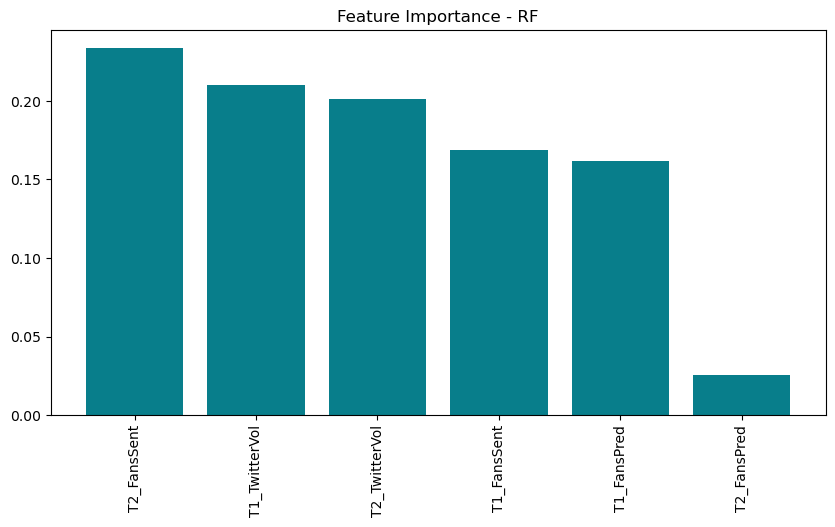

In [58]:
# get importance
importance = grid_search.best_estimator_.feature_importances_
#Important variables
importances_rf = pd.DataFrame(data = {'Attribute': train.drop('Winner', axis=1).columns, 'Importance': grid_search.best_estimator_.feature_importances_})
importances_rf = importances_rf.sort_values(by='Importance', ascending = False)
#plot
plt.figure(figsize=(10,5))
plt.bar(x=importances_rf['Attribute'], height = importances_rf['Importance'], color = '#087E8B')
plt.title('Feature Importance - RF')
plt.xticks(rotation='vertical')
plt.show()

## XGBoost

In [59]:
import xgboost as xgb

In [526]:
# {'n_estimators' : [ 2000],
#     'max_depth': [  2 ],# 1,2
#     'min_child_weight' : [17 ],
#     'gamma' : [  1],
#     'learning_rate' : [ 1e-8 ],
#     'subsample': [    0.4 ], # 0.35 
#     'colsample_bytree':[ 0.35 ],
#     'reg_alpha':[  0.0005 ] 
#     }

In [60]:
model = xgb.XGBClassifier(random_state = 42)

param_grid = [    
     {'learning_rate' :[1e-4],# 8
    'n_estimators':[2000],
 'max_depth':[ 3  ], #3 #4 #8
 'min_child_weight':[1],
 'gamma':[0],
 'subsample':[   0.3  ], #0.3
 'colsample_bytree':[   0.35  ], #0.35
 'objective': ['binary:logistic'],
 'nthread':[4],
 'scale_pos_weight':[1],
 'reg_alpha':[1e-5 ]
    }
]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid= param_grid,  cv=cv, n_jobs = -1, scoring='f1',error_score='raise', verbose=0 )
grid_result = grid_search.fit(xtrain_sm, ytrain_sm)

In [61]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.35,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0001, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=2000, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', ...)

In [62]:
grid_search.best_params_, grid_search.best_score_

({'colsample_bytree': 0.35,
  'gamma': 0,
  'learning_rate': 0.0001,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 2000,
  'nthread': 4,
  'objective': 'binary:logistic',
  'reg_alpha': 1e-05,
  'scale_pos_weight': 1,
  'subsample': 0.3},
 0.6695758730907084)

In [63]:
y_predicted = grid_search.predict(xtrain_sm)

print('\nclassification report -  XG+ SMOTE -Train')
print('\n\n')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print(' ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report -  XG+ SMOTE -Train



              precision    recall  f1-score   support

           0       0.72      0.58      0.64       243
           1       0.65      0.77      0.70       243

    accuracy                           0.67       486
   macro avg       0.68      0.67      0.67       486
weighted avg       0.68      0.67      0.67       486

 ROC AUC =  67.5 %
 Precision =  64.6 %
 Recall =  77.4 %
 Accuracy =  67.5 %
 F1-Score =  70.4 %


array([[140, 103],
       [ 55, 188]], dtype=int64)

In [64]:
# Predict the test data
y_predicted = grid_search.predict( xtest)

print('\nclassification report- XG+ SMOTE -Test')
print('\n\n')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('Random Forest: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report- XG+ SMOTE -Test



              precision    recall  f1-score   support

           0       0.61      0.51      0.56        49
           1       0.62      0.71      0.66        55

    accuracy                           0.62       104
   macro avg       0.61      0.61      0.61       104
weighted avg       0.61      0.62      0.61       104

Random Forest: ROC AUC =  61.0 %
Random Forest: Precision =  61.9 %
Random Forest: Recall =  70.9 %
Random Forest: Accuracy =  61.5 %
Random Forest: F1-Score =  66.1 %


array([[25, 24],
       [16, 39]], dtype=int64)

In [553]:
# filename = 'XG+SMOTE.pkl'
# pickle.dump(grid_search, open(filename, 'wb'))

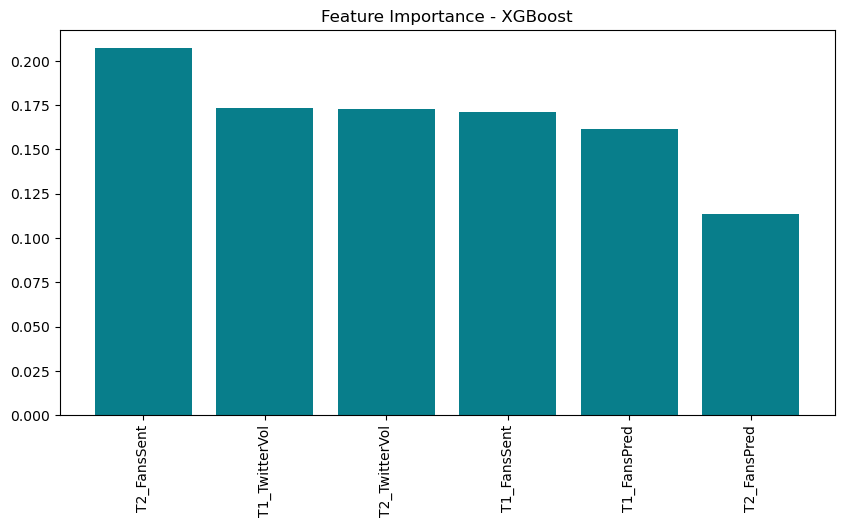

In [65]:
# get importance
importance = grid_search.best_estimator_.feature_importances_
#Important variables
importances_rf = pd.DataFrame(data = {'Attribute': train.drop('Winner', axis=1).columns, 'Importance': grid_search.best_estimator_.feature_importances_})
importances_rf = importances_rf.sort_values(by='Importance', ascending = False)
#plot
plt.figure(figsize=(10,5))
plt.bar(x=importances_rf['Attribute'], height = importances_rf['Importance'], color = '#087E8B')
plt.title('Feature Importance - XGBoost')
plt.xticks(rotation='vertical')
plt.show()

## RF-Pred

In [67]:
xtrain = train.drop(['Winner',   'T2_FansPred', 'T1_FansPred' ],
                    axis=1)
ytrain = train['Winner']
 
xtest = test.drop(['Winner', 'T2_FansPred', 'T1_FansPred' ], axis=1)
ytest = test['Winner']

st = StandardScaler()
xtrain  = st.fit_transform(xtrain)
xtest = st.fit_transform(xtest)

sm = SMOTE(random_state=100)
xtrain_sm, ytrain_sm = sm.fit_resample(  xtrain,ytrain) 
 
xtrain_sm.shape, ytrain_sm.shape 

((486, 4), (486,))

In [68]:
# define models and parameters
model = RandomForestClassifier(random_state = 42)
param_grid = [    
    {'n_estimators' : [2000],
    'criterion': [ 'gini'  ],
    'max_features':[   0.2 ],
     'min_samples_leaf': [ 35, 40, 45], #60
     'oob_score':[True],
     'min_samples_split':[6]
    }
]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid= param_grid, n_jobs=-1,  cv=cv, scoring='f1',error_score='raise')
grid_result = grid_search.fit(xtrain_sm, ytrain_sm)

In [69]:
grid_search.best_params_, grid_search.best_score_

({'criterion': 'gini',
  'max_features': 0.2,
  'min_samples_leaf': 40,
  'min_samples_split': 6,
  'n_estimators': 2000,
  'oob_score': True},
 0.6586346252663398)

In [70]:
y_predicted = grid_search.predict(xtrain_sm)

print('\nclassification report -  RF+ SMOTE -Train')
print('\n\n')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print(' ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report -  RF+ SMOTE -Train



              precision    recall  f1-score   support

           0       0.68      0.49      0.57       243
           1       0.60      0.77      0.68       243

    accuracy                           0.63       486
   macro avg       0.64      0.63      0.62       486
weighted avg       0.64      0.63      0.62       486

 ROC AUC =  63.0 %
 Precision =  60.1 %
 Recall =  77.0 %
 Accuracy =  63.0 %
 F1-Score =  67.5 %


array([[119, 124],
       [ 56, 187]], dtype=int64)

In [71]:
# Predict the test data
y_predicted = grid_search.predict( xtest)

print('\nclassification report- RF+ SMOTE -Test')
print('\n\n')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('Random Forest: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report- RF+ SMOTE -Test



              precision    recall  f1-score   support

           0       0.61      0.47      0.53        49
           1       0.61      0.73      0.66        55

    accuracy                           0.61       104
   macro avg       0.61      0.60      0.59       104
weighted avg       0.61      0.61      0.60       104

Random Forest: ROC AUC =  59.8 %
Random Forest: Precision =  60.6 %
Random Forest: Recall =  72.7 %
Random Forest: Accuracy =  60.6 %
Random Forest: F1-Score =  66.1 %


array([[23, 26],
       [15, 40]], dtype=int64)

In [72]:
# filename = 'RF-Pred+SMOTE.pkl'
# pickle.dump(grid_search, open(filename, 'wb'))

## XGB-Pred

In [74]:
xtrain = train.drop(['Winner',   'T2_FansPred' , 'T1_FansPred' ],
                    axis=1)
ytrain = train['Winner']
 
xtest = test.drop(['Winner', 'T2_FansPred', 'T1_FansPred' ], axis=1)
ytest = test['Winner']

st = StandardScaler()
xtrain  = st.fit_transform(xtrain)
xtest = st.fit_transform(xtest)

sm = SMOTE(random_state=100)
xtrain_sm, ytrain_sm = sm.fit_resample(  xtrain,ytrain) 
 
xtrain_sm.shape, ytrain_sm.shape 

((486, 4), (486,))

In [45]:
# {'n_estimators' : [ 2000],
#     'max_depth': [  2 ],# 1,2
#     'min_child_weight' : [15 ],
#     'gamma' : [  1],
#     'learning_rate' : [ 1e-8 ],#0.000001
#     'subsample': [    0.35], # 0.35 
#     'colsample_bytree':[ 0.5 ],
#     'reg_alpha':[  0.0005 ] 
#     }

In [75]:
model = xgb.XGBClassifier(random_state = 42)

param_grid = [    
    {'learning_rate' :[1e-4],# 4
    'n_estimators':[2000],
 'max_depth':[4], #5
 'min_child_weight':[2], #1
 'gamma':[0],
 'subsample':[   0.6 ], #0.5
 'colsample_bytree':[  0.75], #0.9
 'objective': ['binary:logistic'],
 'nthread':[4],
 'scale_pos_weight':[1],
 'reg_alpha':[1e-5 ]
    }
]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid= param_grid,  cv=cv, n_jobs = -1, scoring='f1',error_score='raise', verbose=0 )
grid_result = grid_search.fit(xtrain_sm, ytrain_sm)

In [76]:
y_predicted = grid_search.predict(xtrain_sm)

print('\nclassification report -  XG+ SMOTE -Train')
print('\n\n')
print(classification_report(ytrain_sm, y_predicted)) # generate the precision, recall, f-1 score, num
print(' ROC AUC = ',str(round(roc_auc_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Precision = ',str(round(precision_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Recall = ',str(round(recall_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' Accuracy = ',str(round(accuracy_score(ytrain_sm, y_predicted)*100,1)), '%')
print(' F1-Score = ',str(round(f1_score(ytrain_sm, y_predicted)*100,1)), '%')
confusion_matrix(ytrain_sm, y_predicted)


classification report -  XG+ SMOTE -Train



              precision    recall  f1-score   support

           0       0.77      0.65      0.70       243
           1       0.70      0.81      0.75       243

    accuracy                           0.73       486
   macro avg       0.73      0.73      0.72       486
weighted avg       0.73      0.73      0.72       486

 ROC AUC =  72.6 %
 Precision =  69.5 %
 Recall =  80.7 %
 Accuracy =  72.6 %
 F1-Score =  74.7 %


array([[157,  86],
       [ 47, 196]], dtype=int64)

In [77]:
# Predict the test data
y_predicted = grid_search.predict( xtest)

print('\nclassification report- XG+ SMOTE -Test')
print('\n\n')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('Random Forest: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report- XG+ SMOTE -Test



              precision    recall  f1-score   support

           0       0.69      0.51      0.59        49
           1       0.65      0.80      0.72        55

    accuracy                           0.66       104
   macro avg       0.67      0.66      0.65       104
weighted avg       0.67      0.66      0.66       104

Random Forest: ROC AUC =  65.5 %
Random Forest: Precision =  64.7 %
Random Forest: Recall =  80.0 %
Random Forest: Accuracy =  66.3 %
Random Forest: F1-Score =  71.5 %


array([[25, 24],
       [11, 44]], dtype=int64)

In [98]:
# filename = 'XG-Pred+SMOTE.pkl'
# pickle.dump(grid_search, open(filename, 'wb'))